# <center> <img src="../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Autumn 2025** </center>
---
### <center> **Streaming processing final project** </center>
---
**Profesor**: Pablo Camarillo Ramirez
**Estudiante**: Santiago Montes de Oca

## Producer (30 points)
The producer is going to create data in continuous mode with kafka. 
<br/>the code is: <br/>
O2025_ESI3914B\spark\notebooks\lib\santiagomdeo\producerStreaming\ **producerStream.py** <br/>

<br/> It is executed with a docker file, and sends the information to the kafka.


## Dataset and Stream creation (10 points)

This section should contain the code to create a stream using Spark Structured Streaming API to consume the data in continuous mode from the selected stream channel (files or kafka).  The information you need to consume in this section should contain the schema generation (with the SparkUtils class) and the correct format and reading options.

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (Kafka)") \
    .master("spark://3a418aad77c6:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c48a2cb8-afcb-49fb-9601-e0fdfedc64b1;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

### Creating Kafka and the topics

cd kafka<br/>
docker compose --file docker-compose.yml up -d<br/>

**create a topic:**<br/>

docker exec -it 31da5decad48 /opt/kafka/bin/kafka-topics.sh --create --topic raw-crawl-telemetry --bootstrap-server localhost:9092 --partitions 1 --replication-factor 1

**show that it exists:**<br/>

docker exec -it 31da5decad48 /opt/kafka/bin/kafka-topics.sh --list --bootstrap-server localhost:9092


In [2]:
topic = "raw-crawl-telemetry"

kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", topic) \
            .load()

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [7]:
from pyspark.sql.functions import from_json, col, min
from pyspark.sql.types import StructField, StringType
from santiagomdeo.spark_utils import SparkUtils

#process the received data:
#this is a single column string probably
crawler_telemetry_df = kafka_df.select(kafka_df.value.cast("string").alias("value_str"))

#format it with my library 
crawler_schema = SparkUtils.generate_schema([("from", "string"), ("to", "string"),("depth", "int"),("timestamp","timestamp")])

#the teacher gave this code
crawler_extracted_df = crawler_telemetry_df.withColumn("telemetry", from_json(crawler_telemetry_df.value_str, crawler_schema))

crawler_extracted_df.printSchema()


string
string
int
timestamp
root
 |-- value_str: string (nullable = true)
 |-- telemetry: struct (nullable = true)
 |    |-- from: string (nullable = true)
 |    |-- to: string (nullable = true)
 |    |-- depth: integer (nullable = true)
 |    |-- timestamp: timestamp (nullable = true)



## Transformations and Actions (15 points)
In this section, you need to provide the code to clean and process data (create new columns, aggregate, run joins, etc.). In this section is NOT expected to have any action.

In [8]:
from pyspark.sql.functions import udf, count              #i made this "udf", so i might be importing something else
from santiagomdeo.utils3 import normalize_url

normalize_url_udf = udf(normalize_url, StringType())

In [9]:
parsed_df = crawler_extracted_df.select(
    col("telemetry.from").alias("from"),
    col("telemetry.to").alias("to"),
    col("telemetry.depth").alias("depth"),
    col("telemetry.timestamp").alias("event_time")
)

parsed_2 = (
    parsed_df
    .withColumn("from_url", normalize_url_udf(col("from")))
    .withColumn("to_url", normalize_url_udf(col("to")))
    .drop("from", "to")
)
cleaned_with_watermark = parsed_2.withWatermark("event_time", "5 minutes")



In [10]:
from pyspark.sql.functions import window

aggregated = (
    cleaned_with_watermark
        .groupBy(
            window(col("event_time"), "1 minute"),
            col("from_url"),
            col("to_url"),
            col("depth")
        )
        .agg(
            count("*").alias("appearances"),
            min("event_time").alias("first_seen")
        )
)


cd to my lib
cd .\spark\notebooks\lib\santiagomdeo\producerStreaming\


### like the great gatsby get it? XD
docker build -t the-great-crawler .

### the actual container run
ctrl + lshift + v (allows to paste as one line)

**also remember the second you start this thing. It fires a few messages so you have to have the output running**

docker run -it
 --network=host
 -v "$(pwd)/verified_domains.txt:/app/verified_domains.txt"
 -v "$(pwd)/../../../../data/metrics_health_output:/data/metrics_health_output"
 the-great-crawler
 https://www.iteso.mx
 2
 localhost:9092
 raw-crawl-telemetry




In [ ]:
# console_query = (
#     aggregated.writeStream
#         .format("console")
#         .outputMode("append")
#         .option("truncate", "false")
#         .start()
# )


25/11/24 03:25:46 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-581345dd-aeb1-40ab-b946-df4e44ca84df. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/11/24 03:25:46 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+------+--------+------+-----+-----------+----------+
|window|from_url|to_url|depth|appearances|first_seen|
+------+--------+------+-----+-----------+----------+
+------+--------+------+-----+-----------+----------+



-------------------------------------------
Batch: 1
-------------------------------------------
+------+--------+------+-----+-----------+----------+
|window|from_url|to_url|depth|appearances|first_seen|
+------+--------+------+-----+-----------+----------+
+------+--------+------+-----+-----------+----------+

-------------------------------------------
Batch: 2
-------------------------------------------
+------+--------+------+-----+-----------+----------+
|window|from_url|to_url|depth|appearances|first_seen|
+------+--------+------+-----+-----------+----------+
+------+--------+------+-----+-----------+----------+

-------------------------------------------
Batch: 3
-------------------------------------------
+------+--------+------+-----+-----------+----------+
|window|from_url|to_url|depth|appearances|first_seen|
+------+--------+------+-----+-----------+----------+
+------+--------+------+-----+-----------+----------+



# Persistence Data (15 points)

Once information is transformed, you need to document the process of persistence data in files using at least one vertical partition (partitionBy).  



In [ ]:
parquet_query = (
    aggregated.writeStream
        .outputMode("append")
        .trigger(processingTime="1 minute")
        .format("parquet")
        .option("path", "/opt/spark/work-dir/data/project02streamingdata/crawler_clean_output/")
        .option("checkpointLocation", "/opt/spark/work-dir/lib/santiagomdeo/producerStreaming/crawler_checkpoint")
        .partitionBy("depth")
        .start()
)


25/11/24 03:30:59 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


25/11/24 03:31:06 ERROR FileFormatWriter: Aborting job f0621a0f-dd44-44c0-8f4b-d3e314e11de6.
org.apache.spark.SparkFileNotFoundException: [BATCH_METADATA_NOT_FOUND] Unable to find batch file:/opt/spark/work-dir/data/project02streamingdata/crawler_clean_output/_spark_metadata/0. SQLSTATE: 42K03
	at org.apache.spark.sql.errors.QueryExecutionErrors$.batchMetadataFileNotFoundError(QueryExecutionErrors.scala:1741)
	at org.apache.spark.sql.execution.streaming.HDFSMetadataLog.applyFnToBatchByStream(HDFSMetadataLog.scala:197)
	at org.apache.spark.sql.execution.streaming.CompactibleFileStreamLog.applyFnInBatch(CompactibleFileStreamLog.scala:210)
	at org.apache.spark.sql.execution.streaming.CompactibleFileStreamLog.foreachInBatch(CompactibleFileStreamLog.scala:196)
	at org.apache.spark.sql.execution.streaming.CompactibleFileStreamLog.$anonfun$compact$3(CompactibleFileStreamLog.scala:238)
	at scala.runtime.java8.JFunction1$mcVJ$sp.apply(JFunction1$mcVJ$sp.scala:18)
	at scala.collection.immutable.

-------------------------------------------
Batch: 4
-------------------------------------------
+------+--------+------+-----+-----------+----------+
|window|from_url|to_url|depth|appearances|first_seen|
+------+--------+------+-----+-----------+----------+
+------+--------+------+-----+-----------+----------+

-------------------------------------------
Batch: 5
-------------------------------------------
+------+--------+------+-----+-----------+----------+
|window|from_url|to_url|depth|appearances|first_seen|
+------+--------+------+-----+-----------+----------+
+------+--------+------+-----+-----------+----------+

-------------------------------------------
Batch: 6
-------------------------------------------
+------+--------+------+-----+-----------+----------+
|window|from_url|to_url|depth|appearances|first_seen|
+------+--------+------+-----+-----------+----------+
+------+--------+------+-----+-----------+----------+

-------------------------------------------
Batch: 7
-----

-------------------------------------------
Batch: 12
-------------------------------------------
+------+--------+------+-----+-----------+----------+
|window|from_url|to_url|depth|appearances|first_seen|
+------+--------+------+-----+-----------+----------+
+------+--------+------+-----+-----------+----------+

-------------------------------------------
Batch: 13
-------------------------------------------
+------+--------+------+-----+-----------+----------+
|window|from_url|to_url|depth|appearances|first_seen|
+------+--------+------+-----+-----------+----------+
+------+--------+------+-----+-----------+----------+

-------------------------------------------
Batch: 14
-------------------------------------------
+------+--------+------+-----+-----------+----------+
|window|from_url|to_url|depth|appearances|first_seen|
+------+--------+------+-----+-----------+----------+
+------+--------+------+-----+-----------+----------+

-------------------------------------------
Batch: 15
-

In [ ]:
console_query.awaitTermination()
parquet_query.awaitTermination()



In [26]:
!rm -rf data/project02streamingdata/crawler_clean_output/{*,.*}

In [27]:

!rm -rf data/project02streamingdata/metrics_health_output/{*,.*}

# Power BI Dashboard (10 points)

With the files generated in the persistence section, you should create a Dashboard using Power BI to summarize and visualize the information you processed in the Data Pipeline



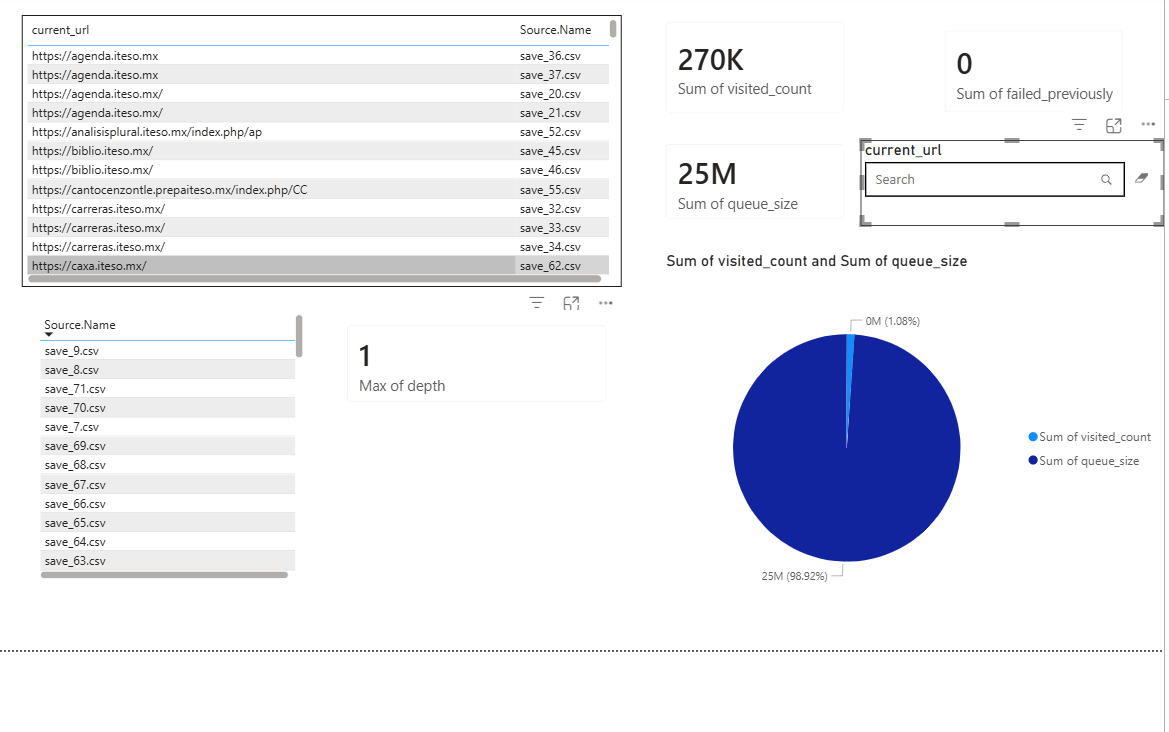

# the text below is purely thoretical and material for questions

### Create a topic:<br/>

docker exec -it 31da5decad48 /opt/kafka/bin/kafka-topics.sh --create --topic crawler-metrics --bootstrap-server localhost:9092 --partitions 1 --replication-factor 1

show that it exists:<br/>

docker exec -it 31da5decad48 /opt/kafka/bin/kafka-topics.sh --list --bootstrap-server localhost:9092


In [ ]:
from santiagomdeo.spark_utils import SparkUtils
from pyspark.sql.functions import from_json, col, min
metrics_health = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "crawler-metrics") \
    .load()

metrics_schema = SparkUtils.generate_schema(
    [
        ("timestamp", "timestamp"),
        ("current_url", "string"),
        ("depth", "int"),
        ("visited_count", "int"),
        ("queue_size", "int"),
        ("errors_count", "int")
    ])

metrics_health_df = metrics_health.select(metrics_health.value.cast("string").alias("value_str"))


#god
extracted_health_df = metrics_health_df.withColumn("health", from_json(metrics_health_df.value_str, metrics_schema))

extracted_health_df.printSchema()


timestamp
string
int
int
int
int
root
 |-- value_str: string (nullable = true)
 |-- health: struct (nullable = true)
 |    |-- timestamp: timestamp (nullable = true)
 |    |-- current_url: string (nullable = true)
 |    |-- depth: integer (nullable = true)
 |    |-- visited_count: integer (nullable = true)
 |    |-- queue_size: integer (nullable = true)
 |    |-- errors_count: integer (nullable = true)



25/11/24 01:11:00 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:11:01 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:11:02 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:11:03 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.


In [5]:
parsed_health_metrics = extracted_health_df.select(
    col("health.timestamp").alias("timestamp"),
    col("health.current_url").alias("current_url"),
    col("health.depth").alias("depth"),
    col("health.visited_count").alias("visited_count"),
    col("health.queue_size").alias("queue_size"),
    col("health.errors_count").alias("errors_count")
)

In [6]:
#every 5 seconds we gonna send the info.
query_metrics = parsed_health_metrics.writeStream \
    .trigger(processingTime="1 minute") \
    .format("parquet") \
    .option("path", "/opt/spark/work-dir/data/project02streamingdata/metrics_health_output/") \
    .option("checkpointLocation", "/opt/spark/work-dir/lib/santiagomdeo/producerStreaming/metrics_health_checkpoint/") \
    .start()

25/11/24 01:10:28 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


25/11/24 01:10:30 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:10:30 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:10:30 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:10:30 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:10:31 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:10:31 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0

In [ ]:
query_metrics.awaitTermination()

25/11/24 01:11:04 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:11:05 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:11:06 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:11:07 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/spark/python/lib/py4j-0.10.9.9-src.zip/py4

KeyboardInterrupt: 

25/11/24 01:11:08 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:11:09 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:11:10 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:11:11 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:11:12 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 01:11:13 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node -1 (localhost/127.0.0

In [25]:
sc.stop()

25/11/24 02:29:06 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1001 (localhost/127.0.0.1:9092) could not be established. Node may not be available.


25/11/24 02:29:07 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1001 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 02:29:08 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1001 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 02:29:09 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1001 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 02:29:10 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1001 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 02:29:11 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1001 (localhost/127.0.0.1:9092) could not be established. Node may not be available.
25/11/24 02:29:12 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1001 (local